<a href="https://colab.research.google.com/github/mateuszbarnacki/SSN-Proj/blob/main/SSN_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importy**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
!pip install tensorflow-addons==0.10.0
import tensorflow_addons
from tensorflow_addons.layers import MultiHeadAttention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


**Przygotowanie danych wejściowych**

In [2]:
data = pd.read_csv("COVID-19 w Polsce - Wzrost.csv", header=None)
data = data.values[2:-1,1]
data = np.array([x[2:] for x in data]).astype(int)

# !pip install tensorflow_datasets
# !pip install -U 'tensorflow-text==2.8.*'

train_data, val_data = data[:700], data[700:]

def linear(x):
  return x

**Architektura modelu**

In [55]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        # periodic
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp)

        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_dense1 = keras.layers.Dense(64, activation='sigmoid')
        self.ff_dense2 = keras.layers.Dense(1, activation=linear)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)
        x = self.ff_norm(inputs + x)

        x = self.ff_dense1(x)
        x = self.ff_dense2(x)

        return x

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', time2vec_dim=1, num_heads=2, head_size=128, ff_dim=None, num_layers=1, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      self.time2vec = Time2Vec(kernel_size=time2vec_dim)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]

        
    def call(self, inputs):
        time_embedding = keras.layers.TimeDistributed(self.time2vec)(inputs) 

        x = K.concatenate([inputs, time_embedding], -1) 

        for attention_layer in self.attention_layers:
            x = attention_layer(x) 

        return K.reshape(x, (-1, x.shape[1] * x.shape[2]))

**Przygotowanie danych z uwzględnieniem ilości dni po jakich następuje predykcja przypadków choroby**

In [29]:
def prepare_X_y(data):
  X_data = []
  y_data = []
  for i in range(len(data)-NR_DAYS):
    X = []
    for j in range(NR_DAYS):
      X.append(data[i+j] / MAX_DATA)
    X_data.append(np.array(X))
    y_data.append(data[i+NR_DAYS] / MAX_DATA)

  X_data = np.array(X_data).reshape(len(X_data),NR_DAYS,1).astype(float)
  y_data = np.array(y_data).reshape(len(y_data),1,1).astype(float)

  return X_data, y_data

**Funkcje pomocnicze do analizy danych**

In [30]:
def prepare_preds(X):
  y_preds = []
  for x in X:
    X_pred = np.array(x).reshape(1,NR_DAYS,1).astype(float)
    y_pred = model.predict(X_pred) * MAX_DATA
    y_preds.append(y_pred[0][-3])
  return y_preds

def draw_predictions(nr_epochs, y_test, y_preds, title):
    epochs = np.arange(nr_epochs)
    plt.figure(figsize=(12,4))

    plt.plot(epochs, y_test, "r")
    plt.plot(epochs, y_preds, "g")
    
    plt.ylabel("Ilość przypadków")
    plt.xlabel('Czas')
    plt.legend(['true', 'pred'], loc='best')
    plt.title("Przewidywania liczby przypadków dla danych " + title)
     
    plt.show()

**Funkcje miary błędu**

In [47]:
def det_coeff(y_true, y_pred):
  SS_res = K.sum(K.square(y_true - y_pred))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return (1. - SS_res/(SS_tot + K.epsilon()))

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def accuracy_m(y_true, y_pred):
  correct_preds = 0
  for i in range(len(y_pred)):
    if y_true[i] == y_pred[i]:
      correct_preds = correct_pred + 1
  return correct_preds / len(y_pred)

def idx_of_agreement(y_true, y_pred):
  up = K.sum(K.square(y_true - y_pred))
  down = K.sum(K.square(K.abs(y_pred - K.mean(y_true)) + (K.abs(y_true - K.mean(y_true)))))
  return (1. - up / (down + K.epsilon()))

**Działanie modelu przy użyciu odgórnego podziału danych na uczące i testujące**

Rozmiar danych uczących: 700.

Rozmiar danych testowych: 39.

Epoch 1/50
22/22 [==============================] - 2s 101ms/step - loss: 0.0581 - val_loss: 0.0373
Epoch 2/50
22/22 [==============================] - 2s 98ms/step - loss: 0.0127 - val_loss: 0.0159
Epoch 3/50
22/22 [==============================] - 2s 100ms/step - loss: 0.0092 - val_loss: 0.0140
Epoch 4/50
22/22 [==============================] - 2s 99ms/step - loss: 0.0082 - val_loss: 0.0133
Epoch 5/50
22/22 [==============================] - 2s 98ms/step - loss: 0.0078 - val_loss: 0.0118
Epoch 6/50
22/22 [==============================] - 2s 101ms/step - loss: 0.0074 - val_loss: 0.0142
Epoch 7/50
22/22 [==============================] - 3s 151ms/step - loss: 0.0069 - val_loss: 0.0132
Epoch 8/50
22/22 [==============================] - 3s 122ms/step - loss: 0.0067 - val_loss: 0.0146
Epoch 9/50
22/22 [==============================] - 2s 97ms/step - loss: 0.0065 - val_loss: 0.0143
Epoch 10/50
22/22 [==============================] - 2s 99ms/step - loss: 0.0064 - val_loss: 0.0123
Epoc

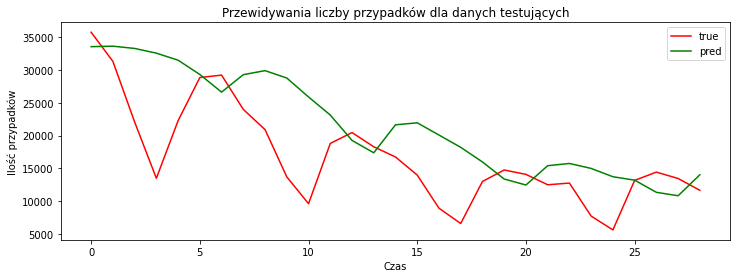

Coefficient of determination: -0.091892004
Index of agreement: 0.751213
Recall: 1.0
Accuracy: 0.0


In [56]:
MAX_DATA = np.max(data)
NR_DAYS = 10

X_train, y_train = prepare_X_y(train_data)

X_test, y_test = prepare_X_y(val_data)

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))

**Podział danych za pomocą Time Series Split**

Ilość podziałów: 5

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114] TEST: [115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 

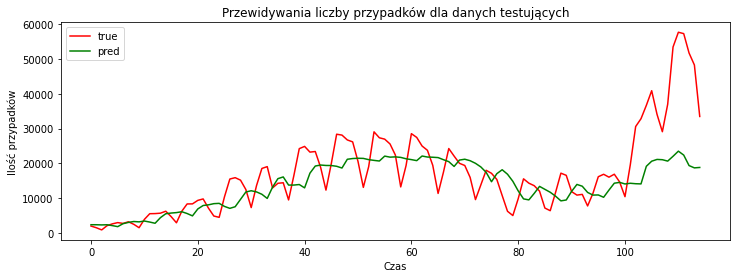

Coefficient of determination: 0.39477235
Index of agreement: 0.724946
Recall: 1.0
Accuracy: 0.0


In [57]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

for train_index, test_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))

Ilość podziałów: 10

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69] TEST: [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 1

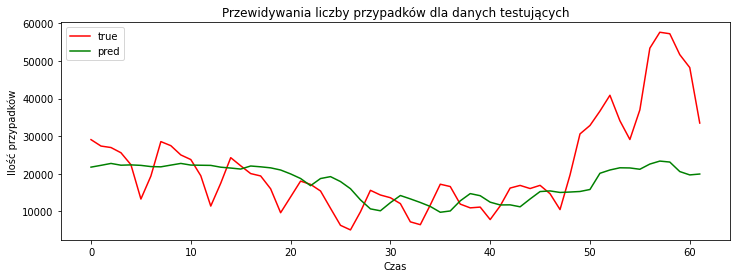

Coefficient of determination: 0.15846825
Index of agreement: 0.5033943
Recall: 1.0
Accuracy: 0.0


In [58]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=10)
print(tscv)

for train_index, test_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))

Ilość podziałów: 8

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None)
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81] TEST: [ 82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  8

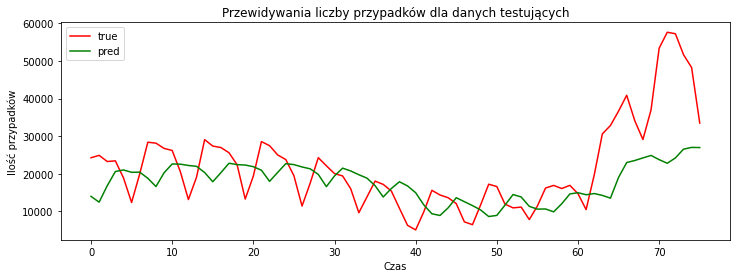

Coefficient of determination: 0.1971904
Index of agreement: 0.5898752
Recall: 1.0
Accuracy: 0.0


In [59]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=8)
print(tscv)

for train_index, test_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))

Ilość podziałów: 2

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 

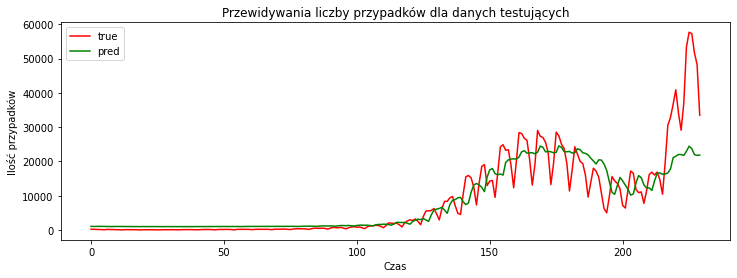

Coefficient of determination: 0.72586656
Index of agreement: 0.90290576
Recall: 1.0
Accuracy: 0.0


In [60]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=2)
print(tscv)

for train_index, test_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))